In [1]:
import pandas as pd

# Helpers
from data.data_builder import alfred_dataset, get_alfred
from models.models_builder import asset_arima, nowcaster, forecast_ma, forecast

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tools.eval_measures import rmse
from epftoolbox.evaluation import GW

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%reload_ext autoreload
%autoreload 2

# ***1 - Data***

In [2]:
indices = ["CPI", "CCPI", "FCPI", "GCPI"]
df = alfred_dataset(indices)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,688,1995-08-16 16:53:01.395348864,1967-01-01 00:00:00,1981-04-23 12:00:00,1995-08-16 12:00:00,2009-12-08 18:00:00,2024-04-01 00:00:00,NaN
CPI,688.0,151.966017,32.9,89.55,153.0,217.3655,313.207,76.740787
CCPI,688.0,156.092715,34.2,87.6,162.0,220.68225,317.622,78.315558
FCPI,688.0,153.538073,33.7,92.8,148.85,219.01,328.267,78.17727
GCPI,688.0,139.073121,26.1,80.4,102.1,211.595,411.984,90.836301


In [3]:
pi_df = 100*df[indices].pct_change()
df[[f'pi-{i}' for i in indices]] = pi_df
df

,date,CPI,CCPI,FCPI,GCPI,pi-CPI,pi-CCPI,pi-FCPI,pi-GCPI
0,1967-01-01,32.900,34.200,33.900,26.300,NaN,NaN,NaN,NaN
1,1967-02-01,33.000,34.200,33.800,26.200,0.303951,0.000000,-0.294985,-0.380228
2,1967-03-01,33.000,34.300,33.800,26.100,0.000000,0.292398,0.000000,-0.381679
3,1967-04-01,33.100,34.400,33.700,26.400,0.303030,0.291545,-0.295858,1.149425
4,1967-05-01,33.100,34.500,33.700,26.400,0.000000,0.290698,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
683,2023-12-01,308.742,313.209,326.545,303.242,0.233099,0.275333,0.207138,-0.570525
684,2024-01-01,309.685,314.438,327.813,293.287,0.305433,0.392390,0.388308,-3.282857
685,2024-02-01,311.054,315.565,327.880,304.302,0.442062,0.358417,0.020438,3.755707
686,2024-03-01,312.230,316.698,328.212,309.587,0.378069,0.359039,0.101257,1.736762


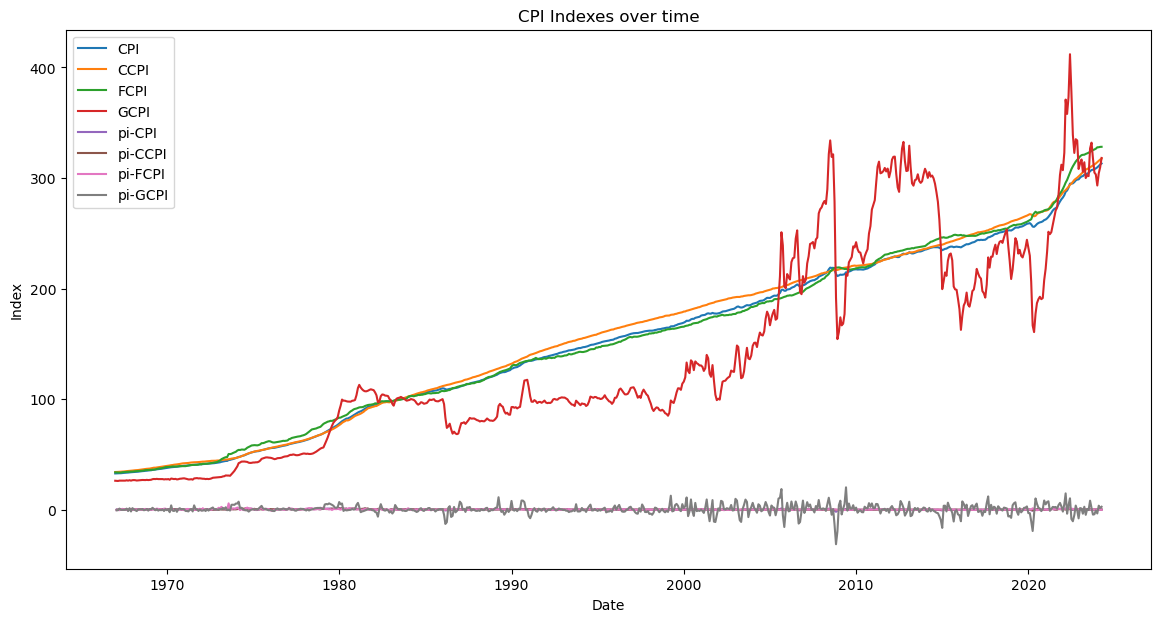

In [4]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date':
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('CPI Indexes over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

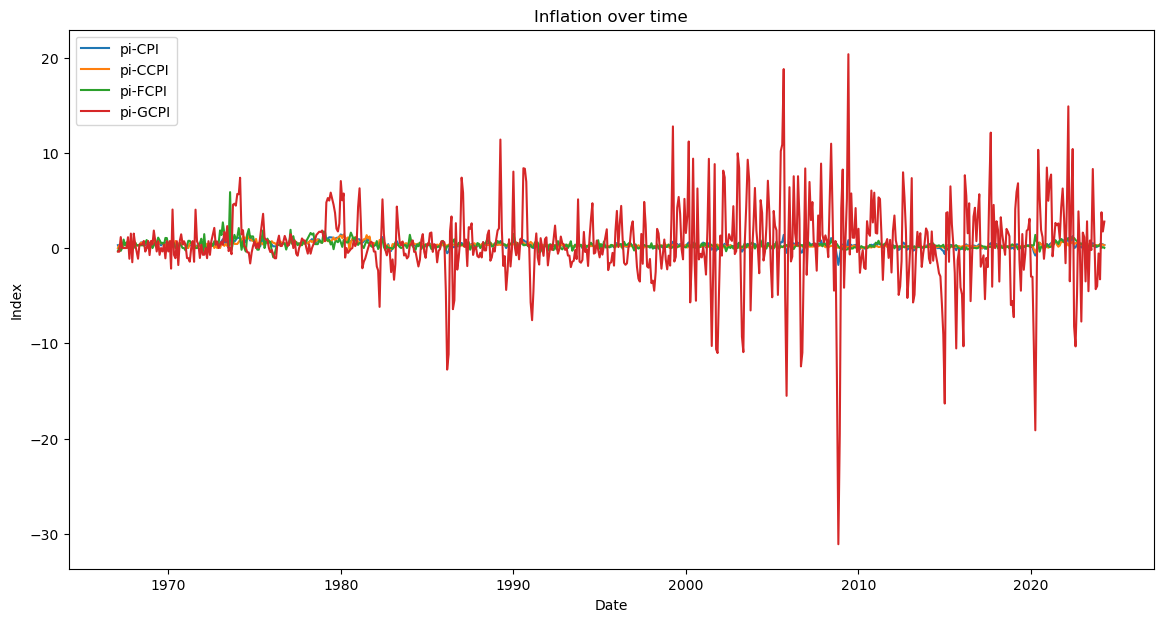

In [5]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date' and col.startswith('pi-'):
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Inflation over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

In [6]:
# Load gasoline data
gasoline_df = pd.read_excel("data/2f. EMM_EPMR_PTE_NUS_DPGw.xls", sheet_name=1, header=2)
gasoline_df['Date'] = pd.to_datetime(gasoline_df['Date'])
gasoline_df = gasoline_df.rename(columns={'Date': 'date', 'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)': 'GasolineNSA'})

# From weekly to monthly data
gasoline_df = gasoline_df.set_index('date').resample('M').mean().reset_index()
gasoline_df['date'] = gasoline_df['date'].dt.to_period('M').dt.to_timestamp()

gasoline_df['pi-GasolineNSA'] = 100*gasoline_df['GasolineNSA'].pct_change()
gasoline_df = gasoline_df.merge(df[['date', 'pi-GCPI']], on='date')

gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI
0,1990-08-01,1.2180,NaN,8.378088
1,1990-09-01,1.2580,3.284072,8.325074
2,1990-10-01,1.3354,6.152623,6.953339
3,1990-11-01,1.3240,-0.853677,0.256630
4,1990-12-01,1.3410,1.283988,0.341297
...,...,...,...,...
400,2023-12-01,3.1340,-5.545509,-0.570525
401,2024-01-01,3.0754,-1.869815,-3.282857
402,2024-02-01,3.2115,4.425441,3.755707
403,2024-03-01,3.4255,6.663553,1.736762


In [7]:
gasoline_df['diff'] = gasoline_df['pi-GasolineNSA'] - gasoline_df['pi-GCPI']
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff
0,1990-08-01,1.2180,NaN,8.378088,NaN
1,1990-09-01,1.2580,3.284072,8.325074,-5.041002
2,1990-10-01,1.3354,6.152623,6.953339,-0.800716
3,1990-11-01,1.3240,-0.853677,0.256630,-1.110306
4,1990-12-01,1.3410,1.283988,0.341297,0.942691
...,...,...,...,...,...
400,2023-12-01,3.1340,-5.545509,-0.570525,-4.974984
401,2024-01-01,3.0754,-1.869815,-3.282857,1.413042
402,2024-02-01,3.2115,4.425441,3.755707,0.669734
403,2024-03-01,3.4255,6.663553,1.736762,4.926791


In [8]:
import numpy as np

gasoline_df['sf'] = [np.mean([gasoline_df['diff'].iloc[i - (j*12)] for j in range(1, 4)]) if i>48 else gasoline_df['diff'].iloc[i] for i in gasoline_df.index]
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff,sf
0,1990-08-01,1.2180,NaN,8.378088,NaN,NaN
1,1990-09-01,1.2580,3.284072,8.325074,-5.041002,-5.041002
2,1990-10-01,1.3354,6.152623,6.953339,-0.800716,-0.800716
3,1990-11-01,1.3240,-0.853677,0.256630,-1.110306,-1.110306
4,1990-12-01,1.3410,1.283988,0.341297,0.942691,0.942691
...,...,...,...,...,...,...
400,2023-12-01,3.1340,-5.545509,-0.570525,-4.974984,-5.056978
401,2024-01-01,3.0754,-1.869815,-3.282857,1.413042,1.871157
402,2024-02-01,3.2115,4.425441,3.755707,0.669734,0.442766
403,2024-03-01,3.4255,6.663553,1.736762,4.926791,4.764837


In [9]:
gasoline_df['pi-Gasoline'] = gasoline_df['pi-GasolineNSA'] - gasoline_df['sf']
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff,sf,pi-Gasoline
0,1990-08-01,1.2180,NaN,8.378088,NaN,NaN,NaN
1,1990-09-01,1.2580,3.284072,8.325074,-5.041002,-5.041002,8.325074
2,1990-10-01,1.3354,6.152623,6.953339,-0.800716,-0.800716,6.953339
3,1990-11-01,1.3240,-0.853677,0.256630,-1.110306,-1.110306,0.256630
4,1990-12-01,1.3410,1.283988,0.341297,0.942691,0.942691,0.341297
...,...,...,...,...,...,...,...
400,2023-12-01,3.1340,-5.545509,-0.570525,-4.974984,-5.056978,-0.488531
401,2024-01-01,3.0754,-1.869815,-3.282857,1.413042,1.871157,-3.740972
402,2024-02-01,3.2115,4.425441,3.755707,0.669734,0.442766,3.982675
403,2024-03-01,3.4255,6.663553,1.736762,4.926791,4.764837,1.898716


In [10]:
df = df.merge(gasoline_df[['date', 'pi-Gasoline']], on='date')
df = df.dropna()
df

,date,CPI,CCPI,FCPI,GCPI,pi-CPI,pi-CCPI,pi-FCPI,pi-GCPI,pi-Gasoline
1,1990-09-01,132.500,137.100,133.600,109.300,0.683891,0.366032,0.300300,8.325074,8.325074
2,1990-10-01,133.400,137.600,134.100,116.900,0.679245,0.364697,0.374251,6.953339,6.953339
3,1990-11-01,133.700,138.000,134.500,117.200,0.224888,0.290698,0.298285,0.256630,0.256630
4,1990-12-01,134.200,138.600,134.600,117.600,0.373972,0.434783,0.074349,0.341297,0.341297
5,1991-01-01,134.700,139.500,135.000,110.900,0.372578,0.649351,0.297177,-5.697279,-5.697279
...,...,...,...,...,...,...,...,...,...,...
400,2023-12-01,308.742,313.209,326.545,303.242,0.233099,0.275333,0.207138,-0.570525,-0.488531
401,2024-01-01,309.685,314.438,327.813,293.287,0.305433,0.392390,0.388308,-3.282857,-3.740972
402,2024-02-01,311.054,315.565,327.880,304.302,0.442062,0.358417,0.020438,3.755707,3.982675
403,2024-03-01,312.230,316.698,328.212,309.587,0.378069,0.359039,0.101257,1.736762,1.898716


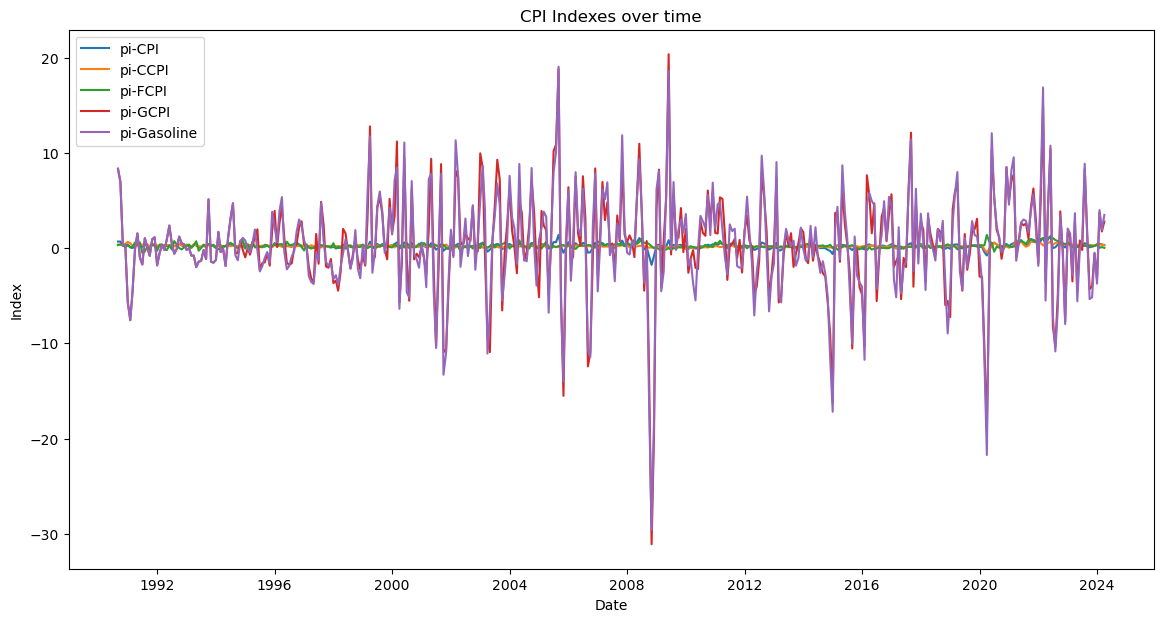

In [11]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date' and col.startswith('pi'):
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('CPI Indexes over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

# ***2 - Models***

In [12]:
models = {}

In [13]:
# Train/Test datesplit
train_t = pd.to_datetime("2000-08-01")

test_start = pd.to_datetime("2000-09-01")
test_end = pd.to_datetime("2023-01-01")
test_range = pd.date_range(test_start, test_end, freq="MS", inclusive="left")

### 2.0 - Baseline: *FED*

In [14]:
xcols = ["pi-CCPI", "pi-FCPI", "pi-Gasoline"]
ycol = "pi-CPI"

# Build nowcaster
model_fed = nowcaster(df, xcols, ycol, train_t)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     138.3
Date:                Wed, 22 May 2024   Prob (F-statistic):           7.25e-26
Time:                        10:07:11   Log-Likelihood:                 92.015
No. Observations:                  60   AIC:                            -176.0
Df Residuals:                      56   BIC:                            -167.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0148      0.020     -0.743      

In [15]:
models.update({'fed': model_fed})

### 2.1 - *Univariate*

In [21]:
xcols = ["pi-CCPI", "pi-FCPI", "pi-Gasoline"]
ycol = "pi-CPI"

coefs = []
for xcol in xcols:
    # Build nowcaster for singlevar
    model_x = nowcaster(df, xcol, ycol, train_t)
    coefs.append(model_x.params)

coefs

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     13.77
Date:                Wed, 22 May 2024   Prob (F-statistic):           0.000465
Time:                        10:07:55   Log-Likelihood:                 34.521
No. Observations:                  60   AIC:                            -65.04
Df Residuals:                      58   BIC:                            -60.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0428      0.047      0.914      0.3

[const      0.042776
 pi-CCPI    0.821451
 dtype: float64,
 const      0.153883
 pi-FCPI    0.233170
 dtype: float64,
 const          0.188022
 pi-Gasoline    0.032481
 dtype: float64]

In [24]:
model_const = np.mean([coef['const'] for coef in coefs])
model_params = [coef.iloc[1] for coef in coefs]
model_params = [model_const, *model_params]
model_params

[0.1282268348367308,
 0.8214511590864852,
 0.23317039067983614,
 0.03248053391243642]

### 2.2 - *News Sentiment Index*

### 2.3 - *GTrend Index*

# 3 - ***Evaluations***

In [17]:
baseline = 'fed'

### 3.1 - *Forcasting*

In [18]:
from functools import reduce

yh = []

#for t in pd.date_range(test_start, test_end, freq="MS", inclusive="left"):
for name, model in models.items():
    model_forecast = forecast(df, model, xcols, ycol, test_range[0], len(test_range))
    model_forecast = model_forecast.rename(columns={'forecast': name})
    yh.append(model_forecast)

yh.append(df[['date', ycol]].rename(columns={ycol: 'realized'}))

forecasts_df = reduce(lambda x, y: x.merge(y, on='date'), yh)

forecasts_df

,date,fed,realized
0,2000-09-01,0.261175,0.521135
1,2000-10-01,0.257242,0.172811
2,2000-11-01,0.257508,0.172513
3,2000-12-01,0.243025,0.229621
4,2001-01-01,0.241970,0.572738
...,...,...,...
263,2022-08-01,0.662467,0.078650
264,2022-09-01,0.660427,0.383457
265,2022-10-01,0.632749,0.513598
266,2022-11-01,0.590757,0.263544


### 3.2 - *Scores*

In [19]:
def GW_adapter(forecasts):
    return np.repeat(forecasts.to_numpy()[:, np.newaxis], 24, axis=1)

In [20]:
res = []

for name, model in models.items():
    # Computing Scores
    rmse_v = rmse(forecasts_df[name], forecasts_df['realized'])
    gw = GW(GW_adapter(forecasts_df['realized']), GW_adapter(forecasts_df[baseline]), GW_adapter(forecasts_df[name]), version='multivariate')

    # Adding to the df
    res.append({'model': name, 'rmse': rmse_v, 'gw': gw})
    # print(f"{'-'*10} {name.upper()} {'-'*10}")
    # print(f"RMSE: {rmse}")
    # print(f"Giacomini-White: {gw}")

# Creating the df
res_df = pd.DataFrame(res)
res_df

,model,rmse,gw
0,fed,0.288567,1.0
